In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# 1.1) Librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb

# 1.2) Carga tus datos
df = pd.read_csv('/content/drive/MyDrive/Proyecto API/Final Csv/all_cards_combined_with_tcg.csv')  # ajusta la ruta

# 1.3) Define variables
numeric_features     = ['cm_avg1', 'cm_avg7', 'cm_avg30', 'cm_trendPrice']
categorical_features = ['rarity', 'supertype', 'subtypes', 'types', 'set_name']
target               = 'cm_averageSellPrice'

# 1.4) Limpia y separa X, y
df_model = df[numeric_features + categorical_features + [target]].dropna()
X = df_model[numeric_features + categorical_features].copy()
y = df_model[target].copy()


In [41]:
# 2.1) Fijamos el umbral (p. ej. 10 €)
threshold = 30.0

# 2.2) Creamos los índices para cada rango
mask_low  = y < threshold
mask_high = y >= threshold

# 2.3) Split train/test para evaluación final
X_tr_low, X_te_low, y_tr_low, y_te_low   = train_test_split(
    X[mask_low], y[mask_low], test_size=0.2, random_state=42
)
X_tr_high, X_te_high, y_tr_high, y_te_high = train_test_split(
    X[mask_high], y[mask_high], test_size=0.2, random_state=42
)


In [42]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')


In [43]:
# ──────────────────────────────────────────────────────────────────────────────
# BLOQUE 4 (modificado): Pipeline para precios bajos con LightGBM (sin warnings)
# ──────────────────────────────────────────────────────────────────────────────

# 4.0) Suprimir los FutureWarnings de sklearn y los logs de LightGBM
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*force_all_finite.*",
    category=FutureWarning
)

# 4.1) Importar librerías necesarias
import numpy as np
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 4.2) Definir el pipeline con parámetros para silenciar LightGBM
pipe_low = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer ya definido
    ('regressor', lgb.LGBMRegressor(
        objective='mae',
        random_state=42,
        n_estimators=100,
        force_row_wise=True,   # elimina el mensaje de “row-wise multi-threading”
        verbosity=-1           # silencia todos los logs de entrenamiento
    ))
])

# 4.3) Entrenar el modelo en log-escala
y_tr_low_log = np.log1p(y_tr_low)
pipe_low.fit(X_tr_low, y_tr_low_log)

# 4.4) Predecir y volver a escala original
y_log_pred_low = pipe_low.predict(X_te_low)
y_pred_low     = np.expm1(y_log_pred_low)

# 4.5) Calcular y mostrar métricas sin generar warnings
rmse_low = np.sqrt(mean_squared_error(y_te_low, y_pred_low))
mae_low  = mean_absolute_error(y_te_low, y_pred_low)
print(f"Low-price → RMSE: {rmse_low:.3f} €, MAE: {mae_low:.3f} €")



Low-price → RMSE: 1.310 €, MAE: 0.390 €


In [44]:
# ──────────────────────────────────────────────────────────────────────────────
# PASO 5 (alternativa): Pipeline para precios altos con LightGBM (MAE) en log-escala
# ──────────────────────────────────────────────────────────────────────────────

# 5.0) Silenciar warnings de sklearn y LightGBM
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*force_all_finite.*")

# 5.1) Importar librerías
import numpy as np
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 5.2) Preprocesador: escala numéricas y codifica categóricas
preprocessor_high = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 5.3) Definir pipeline con LightGBM
pipe_high = Pipeline([
    ('preprocessor', preprocessor_high),
    ('regressor', lgb.LGBMRegressor(
        objective='mae',        # usamos MAE como pérdida
        random_state=42,
        n_estimators=200,       # más árboles para rangos complejos
        force_row_wise=True,    # suprime warning de threading
        verbosity=-1            # silencio total de logs
    ))
])

# 5.4) Entrenar en log-escala con datos de precios altos
y_tr_high_log = np.log1p(y_tr_high)
pipe_high.fit(X_tr_high, y_tr_high_log)

# 5.5) Predecir y volver a escala original
y_log_pred_high = pipe_high.predict(X_te_high)
y_pred_high     = np.expm1(y_log_pred_high)

# 5.6) Calcular métricas
rmse_high = np.sqrt(mean_squared_error(y_te_high, y_pred_high))
mae_high  = mean_absolute_error(y_te_high, y_pred_high)

print(f"High-price → RMSE: {rmse_high:.3f} €, MAE: {mae_high:.3f} €")




High-price → RMSE: 11.160 €, MAE: 6.510 €


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define espacio para pipe_high
param_dist_high = {
    'regressor__n_estimators': randint(50, 500),
    'regressor__max_depth':    [None, 10, 20, 30],
    'regressor__num_leaves':   randint(20, 200),
    'regressor__min_child_samples': randint(5, 50)
}

search_high = RandomizedSearchCV(
    pipe_high,
    param_distributions=param_dist_high,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Entrena solo con las cartas caras (log-transform)
search_high.fit(X_tr_high, np.log1p(y_tr_high))
best_high = search_high.best_estimator_

print("High-price best params:", search_high.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
High-price best params: {'regressor__max_depth': 30, 'regressor__min_child_samples': 25, 'regressor__n_estimators': 152, 'regressor__num_leaves': 141}


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred_high = np.expm1(best_high.predict(X_te_high))
print("High-price tuned → RMSE:", np.sqrt(mean_squared_error(y_te_high, y_pred_high)))
print("                 MAE: ", mean_absolute_error(y_te_high, y_pred_high))


High-price tuned → RMSE: 11.093459309481611
                 MAE:  6.6255575480459505


In [47]:
def predict_mixed(X_new):
    """
    Para cada fila de X_new:
    - Si cm_avg7 < threshold: usa pipe_low
    - Si cm_avg7 >= threshold: usa pipe_high
    """
    # Predecir con ambos y seleccionar según umbral
    # Asegúrate de aplicar el mismo log/expm1
    y_low_log  = pipe_low.predict(X_new[X_new['cm_avg7'] < threshold])
    y_high_log = pipe_high.predict(X_new[X_new['cm_avg7'] >= threshold])
    y_out = pd.Series(index=X_new.index, dtype=float)
    y_out[X_new['cm_avg7'] < threshold]   = np.expm1(y_low_log)
    y_out[X_new['cm_avg7'] >= threshold]  = np.expm1(y_high_log)
    return y_out


In [48]:
# Predecir usando ambos modelos según umbral
y_pred_mixed = predict_mixed(X)

# Evaluar contra los precios reales
rmse_mix = np.sqrt(mean_squared_error(y, y_pred_mixed))
mae_mix = mean_absolute_error(y, y_pred_mixed)

print(f"📈 Modelo mixto (global):")
print(f"  → RMSE: {rmse_mix:.2f} €")
print(f"  → MAE:  {mae_mix:.2f} €")



📈 Modelo mixto (global):
  → RMSE: 3.31 €
  → MAE:  0.68 €


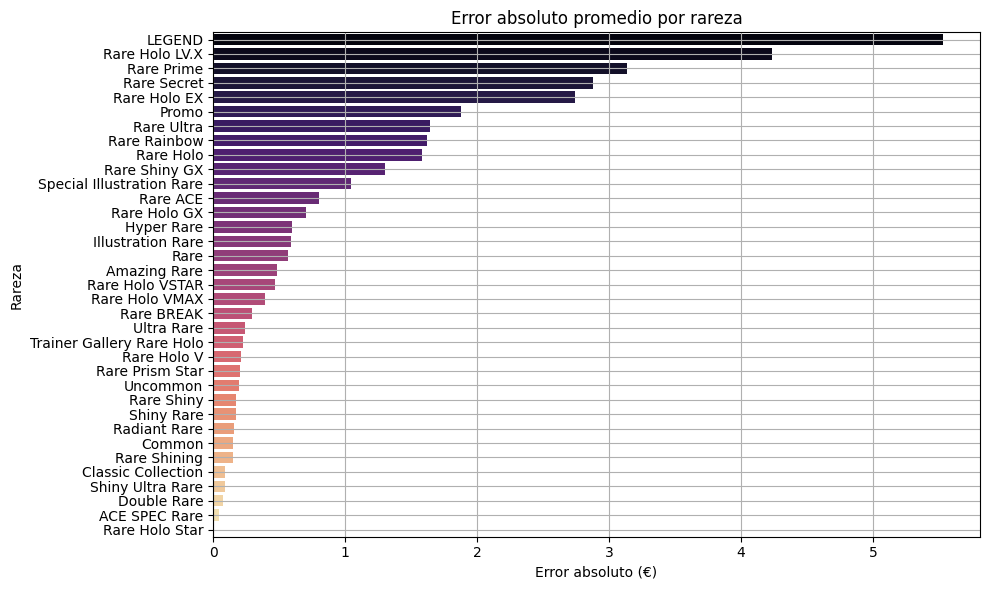

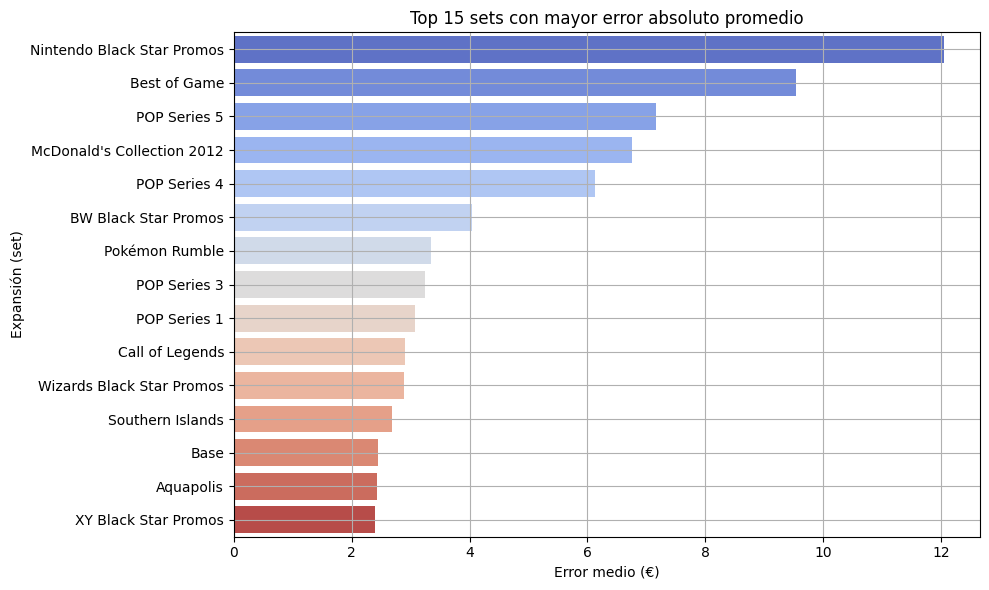

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Asegurarse de tener columnas únicas y necesarias
columnas_seguras = list(set(numeric_features + categorical_features + ['name', 'rarity', 'set_name', 'cm_averageSellPrice']))
df_resultado = df[columnas_seguras].dropna().copy()

# Agregar predicciones
df_resultado["Precio estimado"] = y_pred_mixed.values
df_resultado["Diferencia (€)"] = df_resultado["cm_averageSellPrice"] - df_resultado["Precio estimado"]
df_resultado["Error (%)"] = ((df_resultado["Diferencia (€)"]) / df_resultado["Precio estimado"]) * 100
df_resultado["Error absoluto"] = np.abs(df_resultado["Diferencia (€)"])

# 1. Error absoluto promedio por rareza
rareza_error = df_resultado.groupby("rarity")["Error absoluto"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=rareza_error.values,
    y=rareza_error.index,
    hue=rareza_error.index,
    palette=sns.color_palette("magma", len(rareza_error)),
    legend=False
)
plt.title("Error absoluto promedio por rareza")
plt.xlabel("Error absoluto (€)")
plt.ylabel("Rareza")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Top 15 sets con mayor error absoluto promedio
set_error = df_resultado.groupby("set_name")["Error absoluto"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=set_error.values,
    y=set_error.index,
    hue=set_error.index,
    palette=sns.color_palette("coolwarm", len(set_error)),
    legend=False
)
plt.title("Top 15 sets con mayor error absoluto promedio")
plt.xlabel("Error medio (€)")
plt.ylabel("Expansión (set)")
plt.grid(True)
plt.tight_layout()
plt.show()


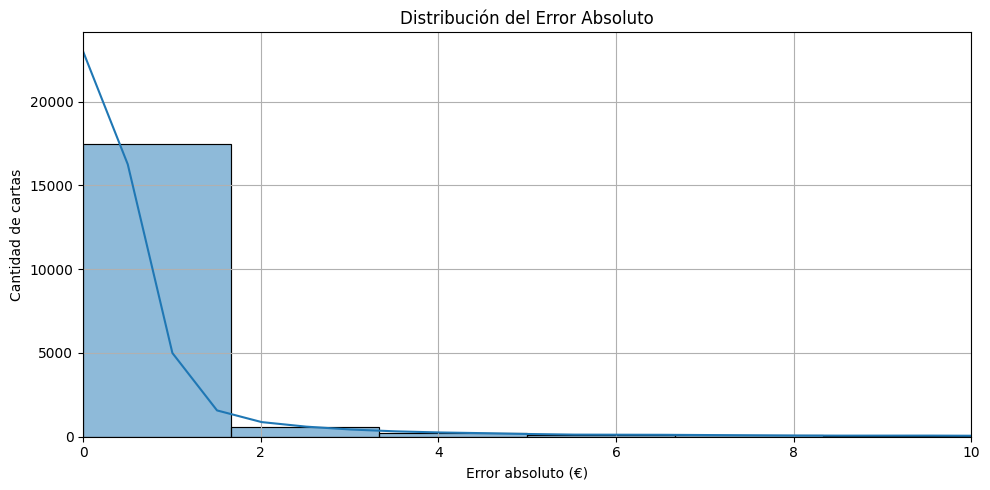

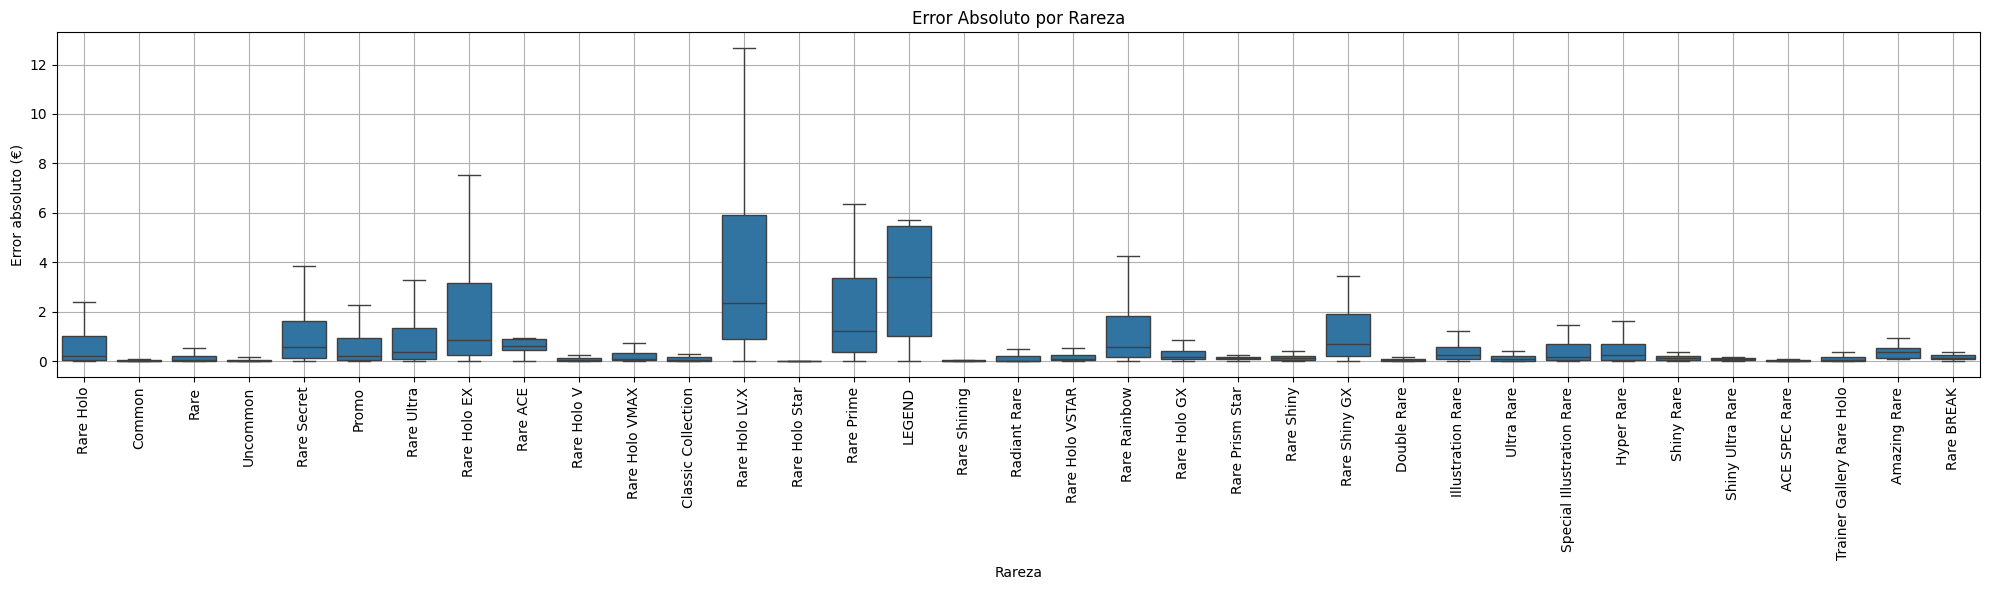

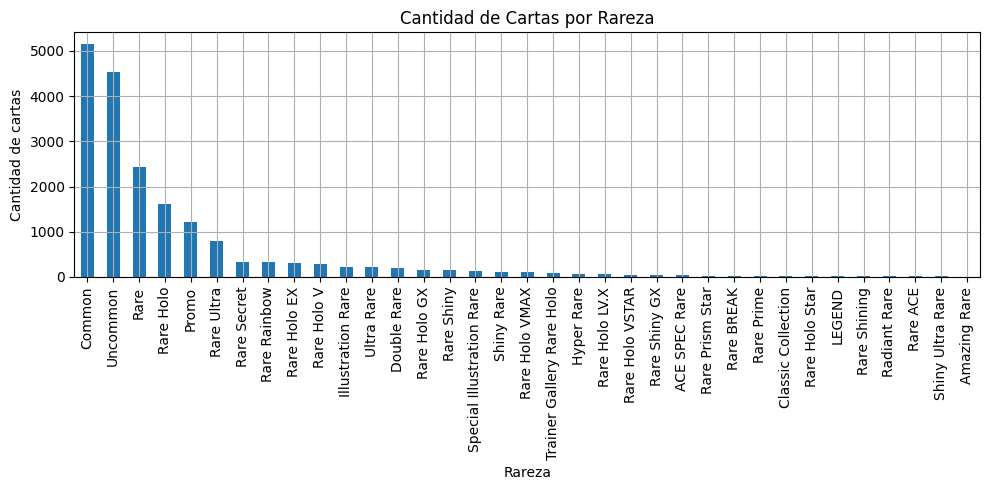

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Asegurarse de tener df_resultado con columnas necesarias
# Si no lo tenés aún:
# df_resultado = df[columnas_seguras].dropna().copy()
# df_resultado["Precio estimado"] = y_pred_mixed.values
# df_resultado["Diferencia (€)"] = df_resultado["cm_averageSellPrice"] - df_resultado["Precio estimado"]
# df_resultado["Error absoluto"] = np.abs(df_resultado["Diferencia (€)"])

# 1. Distribución del error absoluto
plt.figure(figsize=(10, 5))
sns.histplot(df_resultado["Error absoluto"], bins=60, kde=True)
plt.title("Distribución del Error Absoluto")
plt.xlabel("Error absoluto (€)")
plt.ylabel("Cantidad de cartas")
plt.xlim(0, 10)

plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Boxplot de error absoluto por rareza (sin superposición)
plt.figure(figsize=(20, 6))  # más ancho para más rarezas
sns.boxplot(data=df_resultado, x="rarity", y="Error absoluto", showfliers=False)
plt.title("Error Absoluto por Rareza")
plt.xlabel("Rareza")
plt.ylabel("Error absoluto (€)")
plt.xticks(rotation=90)
 # rotación vertical para mejor lectura
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. Cantidad de cartas por rareza
plt.figure(figsize=(10, 5))
df_resultado["rarity"].value_counts().plot(kind='bar')
plt.title("Cantidad de Cartas por Rareza")
plt.xlabel("Rareza")
plt.ylabel("Cantidad de cartas")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
# 1. Top 5 sets con mayor error absoluto promedio
top_sets = df_resultado.groupby("set_name")["Error absoluto"].mean().sort_values(ascending=False).head(5)
top_sets_names = top_sets.index.tolist()

print("📦 Sets con mayor error absoluto promedio:\n")
print(top_sets)

# 2. ¿Cuántas cartas tiene cada set?
print("\n🔢 Número de cartas por set:")
print(df_resultado["set_name"].value_counts().loc[top_sets_names])

# 3. Estadísticas de precio por set (media, desviación, etc.)
print("\n💰 Estadísticas de precios reales por set:")
precios_stats = df_resultado[df_resultado["set_name"].isin(top_sets_names)].groupby("set_name")["cm_averageSellPrice"].describe()
display(precios_stats)

# 4. Rarezas presentes en cada set
print("\n🌟 Rarezas más frecuentes por set:")
rareza_por_set = df_resultado[df_resultado["set_name"].isin(top_sets_names)].groupby(["set_name", "rarity"]).size().unstack(fill_value=0)
display(rareza_por_set)

# 5. Cartas con mayor error en esos sets
print("\n🔍 Cartas con mayor error absoluto en los sets problemáticos:")
errores_altos = df_resultado[df_resultado["set_name"].isin(top_sets_names)].sort_values(by="Error absoluto", ascending=False).head(10)
display(errores_altos[["name", "set_name", "rarity", "cm_averageSellPrice", "Precio estimado", "Error absoluto"]])


📦 Sets con mayor error absoluto promedio:

set_name
Nintendo Black Star Promos    12.056428
Best of Game                   9.538308
POP Series 5                   7.161728
McDonald's Collection 2012     6.763034
POP Series 4                   6.134973
Name: Error absoluto, dtype: float64

🔢 Número de cartas por set:
set_name
Nintendo Black Star Promos    40
Best of Game                   9
POP Series 5                  17
McDonald's Collection 2012    12
POP Series 4                  17
Name: count, dtype: int64

💰 Estadísticas de precios reales por set:


,count,mean,std,min,25%,50%,75%,max
set_name,,,,,,,,
Best of Game,9.0,29.974444,27.555068,0.00,13.4500,19.330,39.9300,85.0
McDonald's Collection 2012,12.0,18.165000,6.908958,6.99,15.4475,17.750,19.9925,30.0
Nintendo Black Star Promos,40.0,31.447250,33.091435,0.00,5.4700,21.325,40.6425,100.0
POP Series 4,17.0,25.417647,35.791564,0.94,1.7200,10.470,22.0000,100.0
POP Series 5,17.0,31.931176,41.088308,1.83,4.3100,8.000,58.8300,100.0



🌟 Rarezas más frecuentes por set:


rarity,Common,Promo,Rare,Uncommon
set_name,,,,
Best of Game,0,9,0,0
McDonald's Collection 2012,12,0,0,0
Nintendo Black Star Promos,0,40,0,0
POP Series 4,6,0,6,5
POP Series 5,6,0,6,5



🔍 Cartas con mayor error absoluto en los sets problemáticos:


,name,set_name,rarity,cm_averageSellPrice,Precio estimado,Error absoluto
6755,Championship Arena,Nintendo Black Star Promos,Promo,0.00,99.999989,99.999989
6770,Mudkip,Nintendo Black Star Promos,Promo,0.00,99.999989,99.999989
6772,Treecko,Nintendo Black Star Promos,Promo,9.50,99.999938,90.499938
7448,Ho-Oh,POP Series 5,Rare,100.00,21.326564,78.673436
7440,Deoxys δ,POP Series 4,Rare,100.00,39.174877,60.825123
6750,Metang,Nintendo Black Star Promos,Promo,100.00,49.292711,50.707289
6737,Marshtomp,Nintendo Black Star Promos,Promo,0.00,45.684149,45.684149
605,Hitmonchan,Best of Game,Promo,0.00,41.784524,41.784524
7451,Pikachu,POP Series 5,Common,14.28,40.236540,25.956540
6249,Axew,McDonald's Collection 2012,Common,29.99,9.895354,20.094646


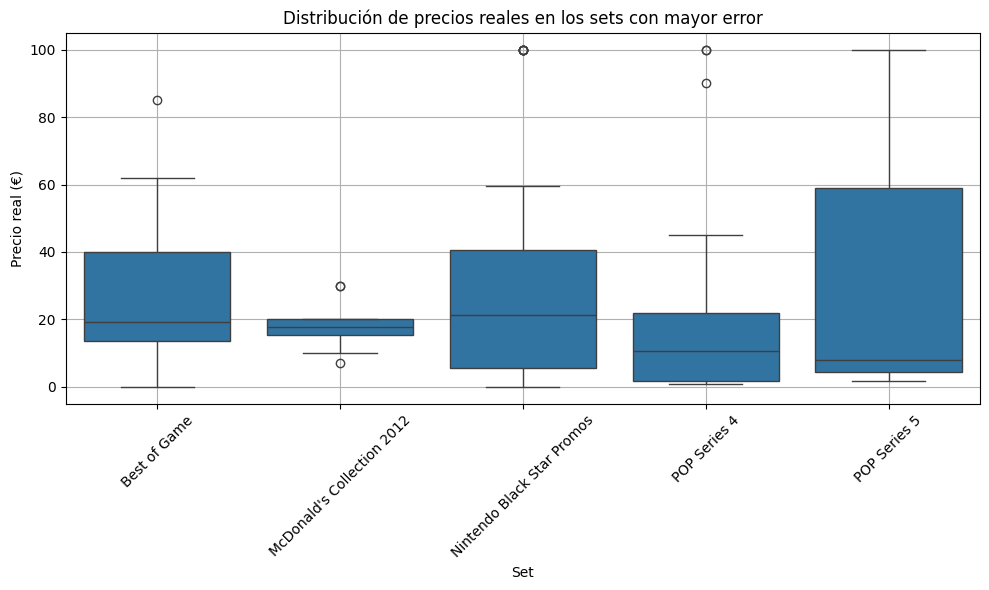

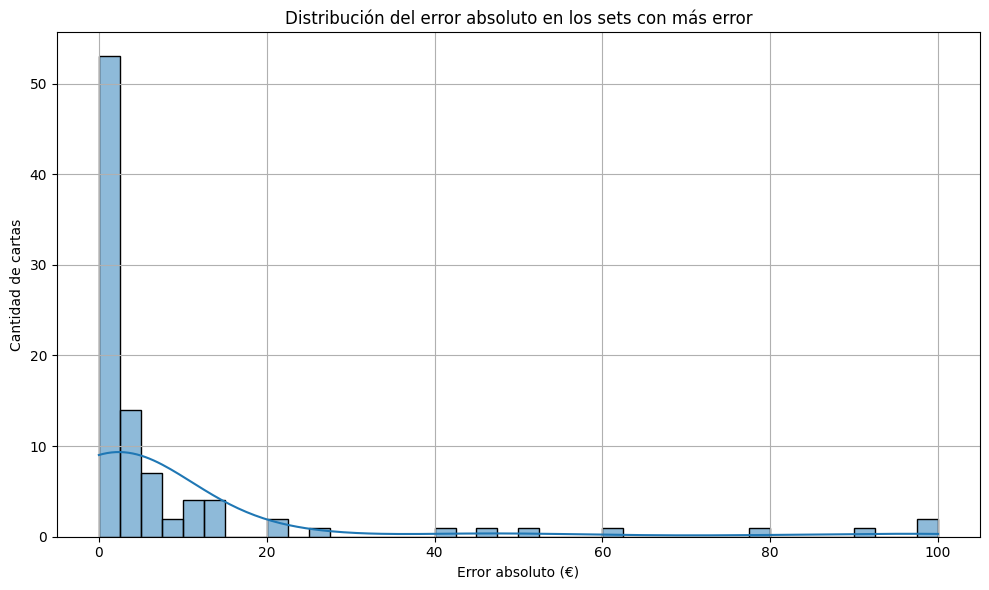

<Figure size 1000x600 with 0 Axes>

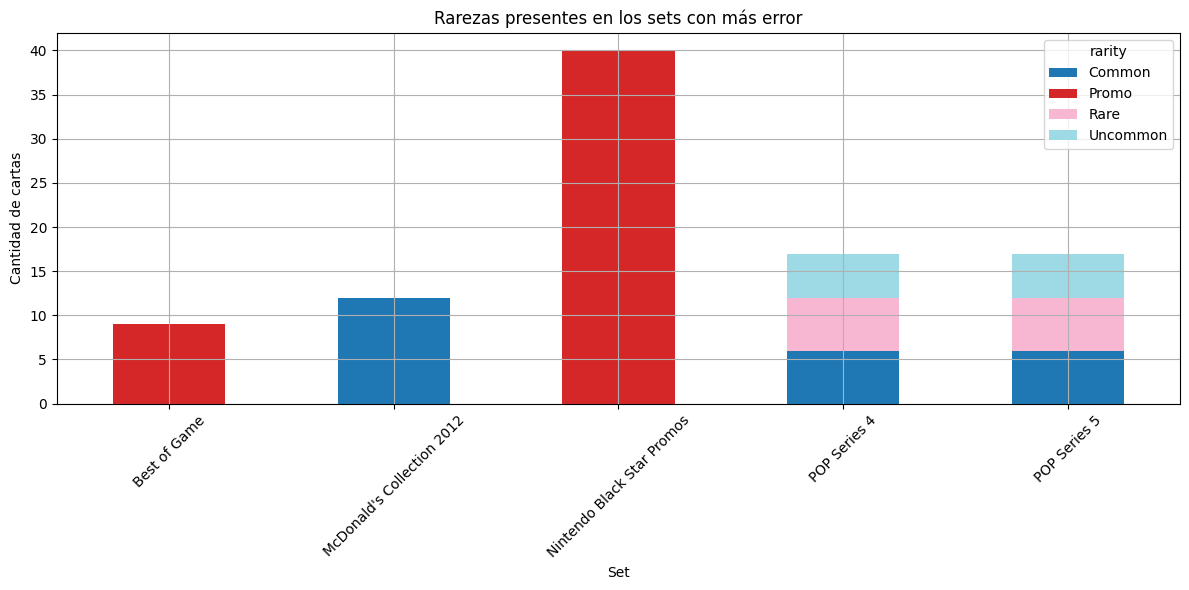

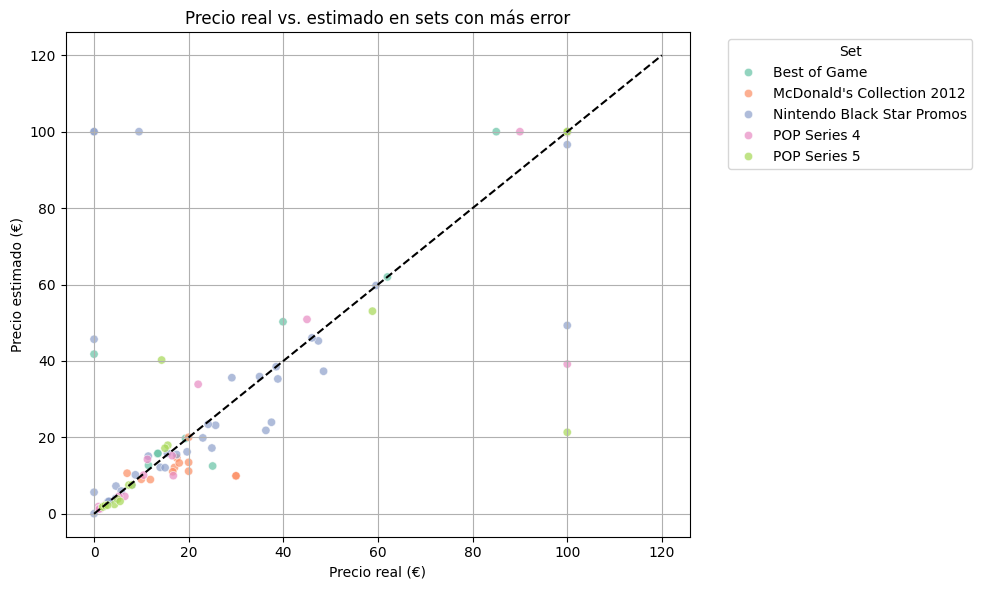

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Subset de los sets problemáticos
df_top_sets = df_resultado[df_resultado["set_name"].isin(top_sets.index)]

# 1. Boxplot de precios por set
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top_sets, x="set_name", y="cm_averageSellPrice")
plt.title("Distribución de precios reales en los sets con mayor error")
plt.xlabel("Set")
plt.ylabel("Precio real (€)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Distribución del error absoluto en esos sets
plt.figure(figsize=(10, 6))
sns.histplot(df_top_sets["Error absoluto"], bins=40, kde=True)
plt.title("Distribución del error absoluto en los sets con más error")
plt.xlabel("Error absoluto (€)")
plt.ylabel("Cantidad de cartas")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Conteo de rarezas por set (gráfico apilado)
plt.figure(figsize=(10, 6))
rareza_stacked = df_top_sets.groupby(["set_name", "rarity"]).size().unstack(fill_value=0)
rareza_stacked.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Rarezas presentes en los sets con más error")
plt.xlabel("Set")
plt.ylabel("Cantidad de cartas")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatterplot: Precio real vs. Precio estimado por set
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top_sets,
    x="cm_averageSellPrice",
    y="Precio estimado",
    hue="set_name",
    alpha=0.7,
    palette="Set2"
)
plt.plot([0, 120], [0, 120], 'k--')  # línea de referencia ideal
plt.title("Precio real vs. estimado en sets con más error")
plt.xlabel("Precio real (€)")
plt.ylabel("Precio estimado (€)")
plt.grid(True)
plt.legend(title="Set", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [53]:
# Crear df_resultado con columnas necesarias
columnas_seguras = list(set(numeric_features + categorical_features + ['name', 'rarity', 'set_name', 'cm_averageSellPrice', 'cm_avg7', 'cm_avg30']))
df_resultado = df[columnas_seguras].dropna().copy()

# Agregar predicciones del modelo mixto
df_resultado["Precio estimado"] = predict_mixed(df_resultado[numeric_features + categorical_features])

# Diferencias y errores
df_resultado["Diferencia (€)"] = df_resultado["cm_averageSellPrice"] - df_resultado["Precio estimado"]
df_resultado["Error absoluto"] = np.abs(df_resultado["Diferencia (€)"])


In [55]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Columnas que usa el modelo
columns_modelo = [
    'cm_avg1', 'cm_avg7', 'cm_avg30', 'cm_trendPrice',
    'rarity', 'supertype', 'subtypes', 'types', 'set_name'
]
target = 'cm_averageSellPrice'

def test_set_future(set_name):
    """
    Para un set dado, filtra las cartas, predice el precio actual
    y proyecta la evolución a 1, 3 y 6 meses (lineal y exponencial).
    Muestra métricas y ejemplos.
    """
    # Filtrar solo filas completas
    df_set = df[df['set_name'] == set_name].dropna(subset=columns_modelo + [target])
    if df_set.empty:
        print(f"❌ No hay datos suficientes para el set '{set_name}'.\n")
        return

    # X, y reales y predicho actual
    X_set = df_set[columns_modelo]
    y_set = df_set[target]
    y_pred = predict_mixed(X_set)

    # Base de resultados
    df_res = df_set[['name', target, 'cm_avg7', 'cm_avg30']].copy()
    df_res['Predicho'] = y_pred
    df_res['Error (€)'] = np.abs(df_res[target] - df_res['Predicho'])

    # 1) Tasa de cambio lineal diaria
    df_res['daily_delta_lin'] = (df_res['cm_avg7'] - df_res['cm_avg30']) / (30 - 7)

    # 2) Proyección lineal a 1m, 3m, 6m
    for days, label in [(30, '1m'), (90, '3m'), (180, '6m')]:
        df_res[f'pred_lin_{label}'] = df_res[target] + df_res['daily_delta_lin'] * days

    # 3) Factor de crecimiento diario (exponencial)
    df_res['daily_factor_exp'] = (df_res['cm_avg7'] / df_res['cm_avg30']) ** (1/(30-7))

    # 4) Proyección exponencial a 1m, 3m, 6m
    for days, label in [(30, '1m'), (90, '3m'), (180, '6m')]:
        df_res[f'pred_exp_{label}'] = df_res[target] * (df_res['daily_factor_exp'] ** days)

    # Métricas actuales
    rmse = np.sqrt(mean_squared_error(y_set, y_pred))
    mae  = mean_absolute_error(y_set, y_pred)
    print(f"📦 Set: {set_name}")
    print(f"   → RMSE actual: {rmse:.2f} €")
    print(f"   → MAE  actual: {mae:.2f} €")

    # Métricas de proyección (media del incremento)
    for label in ['1m', '3m', '6m']:
        inc_lin = (df_res[f'pred_lin_{label}'] - df_res[target]).mean()
        inc_exp = (df_res[f'pred_exp_{label}'] - df_res[target]).mean()
        print(f"   → Incremento medio LINEAL {label}: +{inc_lin:.2f} €")
        print(f"   → Incremento medio EXP {label}:    +{inc_exp:.2f} €")
    print()

    # Mostrar ejemplos
    cols = ['name', target, 'Predicho', 'Error (€)',
            'pred_lin_1m', 'pred_lin_3m', 'pred_lin_6m',
            'pred_exp_1m', 'pred_exp_3m', 'pred_exp_6m']
    display(df_res[cols].sort_values('Error (€)', ascending=False).head(10))

# Elegir 5 sets aleatorios y evaluarlos
sets_aleatorios = np.random.choice(df['set_name'].unique(), size=5, replace=False)
print("🔀 Proyecciones en 5 sets aleatorios:\n")
for s in sets_aleatorios:
    test_set_future(s)


🔀 Proyecciones en 5 sets aleatorios:

📦 Set: Platinum
   → RMSE actual: 2.74 €
   → MAE  actual: 0.68 €
   → Incremento medio LINEAL 1m: +0.11 €
   → Incremento medio EXP 1m:    +0.33 €
   → Incremento medio LINEAL 3m: +0.32 €
   → Incremento medio EXP 3m:    +2.60 €
   → Incremento medio LINEAL 6m: +0.64 €
   → Incremento medio EXP 6m:    +18.69 €



,name,cm_averageSellPrice,Predicho,Error (€),pred_lin_1m,pred_lin_3m,pred_lin_6m,pred_exp_1m,pred_exp_3m,pred_exp_6m
6995,Vulpix,0.00,24.112113,24.112113,-3.443478,-10.330435,-20.660870,0.000000,0.000000,0.000000
6894,Shaymin LV.X,26.50,13.831541,12.668459,35.904348,54.713043,82.926087,48.522549,162.681838,998.693601
6993,Lotad,8.00,19.633039,11.633039,11.717391,19.152174,30.304348,9.612774,13.879258,24.079226
6994,Swablu,28.99,36.934120,7.944120,42.776957,70.350870,111.711739,49.940962,148.208898,757.705328
6896,Hitmonchan,9.26,12.725006,3.465006,12.729565,19.668696,30.077391,12.032926,20.318505,44.583329
6890,Drapion LV.X,14.20,10.981291,3.218709,7.873913,-4.778261,-23.756522,7.880520,2.427101,0.414846
6889,Dialga G LV.X,10.99,13.344017,2.354017,13.037826,17.133478,23.276957,12.858906,17.604217,28.199132
6893,Shaymin LV.X,17.78,19.988461,2.208461,28.462609,49.827826,81.875652,30.277819,87.803180,433.599463
6892,Palkia G LV.X,9.51,11.634701,2.124701,3.901304,-7.316087,-24.142174,5.828444,2.189257,0.503980
6897,Rampardos,3.53,1.619594,1.910406,1.508261,-2.535217,-8.600435,1.380126,0.210963,0.012608


📦 Set: XY Black Star Promos
   → RMSE actual: 5.82 €
   → MAE  actual: 2.39 €
   → Incremento medio LINEAL 1m: +1.56 €
   → Incremento medio EXP 1m:    +2.95 €
   → Incremento medio LINEAL 3m: +4.68 €
   → Incremento medio EXP 3m:    +22.12 €
   → Incremento medio LINEAL 6m: +9.35 €
   → Incremento medio EXP 6m:    +311.25 €



,name,cm_averageSellPrice,Predicho,Error (€),pred_lin_1m,pred_lin_3m,pred_lin_6m,pred_exp_1m,pred_exp_3m,pred_exp_6m
18843,Jirachi,100.00,62.126257,37.873743,144.413043,233.239130,366.478261,188.445682,669.204062,4478.340764
18698,Mew-EX,34.95,64.938347,29.988347,43.415217,60.345652,85.741304,39.285165,49.635385,70.491315
18802,Champions Festival,100.00,73.898070,26.101930,153.582609,260.747826,421.495652,199.368847,792.450044,6279.770730
18867,Champions Festival,65.99,88.919265,22.929265,23.637826,-61.066522,-188.123043,39.544181,14.200103,3.055659
18754,Champions Festival,70.98,93.184982,22.204982,56.410435,27.271304,-16.437391,60.819088,44.652699,28.090498
18717,Magikarp,30.01,51.333895,21.323895,62.318696,126.936087,223.862174,57.581715,211.993132,1497.537089
18863,M Swampert-EX,22.13,41.113684,18.983684,35.708261,62.864783,103.599565,36.001970,95.283124,410.251859
18697,Mewtwo-EX,36.15,53.979557,17.829557,36.554348,37.363043,38.576087,36.420574,36.967811,37.804124
18702,Machamp,27.33,9.725754,17.604246,27.277826,27.173478,27.016957,27.184885,26.896963,26.470787
18701,Zygarde,25.98,10.310106,15.669894,39.532174,66.636522,107.293043,73.997089,600.296219,13870.498475


📦 Set: Plasma Blast
   → RMSE actual: 4.59 €
   → MAE  actual: 1.33 €
   → Incremento medio LINEAL 1m: +0.12 €
   → Incremento medio EXP 1m:    +0.67 €
   → Incremento medio LINEAL 3m: +0.36 €
   → Incremento medio EXP 3m:    +4.82 €
   → Incremento medio LINEAL 6m: +0.72 €
   → Incremento medio EXP 6m:    +32.40 €



,name,cm_averageSellPrice,Predicho,Error (€),pred_lin_1m,pred_lin_3m,pred_lin_6m,pred_exp_1m,pred_exp_3m,pred_exp_6m
733,Virizion,100.00,71.081257,28.918743,126.113043,178.339130,256.678261,152.467378,354.430258,1256.208081
735,Rare Candy,81.06,59.147216,21.912784,86.564348,97.573043,114.086087,89.756311,110.047908,149.402197
731,Iris,50.80,68.030044,17.230044,58.691304,74.473913,98.147826,56.715346,70.692662,98.375049
732,Exeggcute,86.67,70.796702,15.873298,80.670000,68.670000,50.670000,78.706430,64.907226,48.609069
831,Jirachi-EX,38.37,24.489896,13.880104,13.248261,-36.995217,-112.360435,19.685774,5.181719,0.699771
832,Dialga-EX,65.78,56.223757,9.556243,54.784348,32.793043,-0.193913,54.349015,37.101142,20.925734
795,Dialga-EX,11.90,16.307731,4.407731,6.943478,-2.969565,-17.839130,8.610981,4.508831,1.708366
794,Salamence,8.50,4.216662,4.283338,12.034783,19.104348,29.708696,17.329270,72.028269,610.361357
757,Kyurem-EX,10.48,7.754450,2.725550,12.149565,15.488696,20.497391,12.911101,19.595993,36.641501
829,Virizion-EX,23.60,21.323210,2.276790,22.113043,19.139130,14.678261,22.030372,19.197358,15.616040


📦 Set: Deoxys
   → RMSE actual: 4.11 €
   → MAE  actual: 1.06 €
   → Incremento medio LINEAL 1m: +-0.26 €
   → Incremento medio EXP 1m:    +1.59 €
   → Incremento medio LINEAL 3m: +-0.78 €
   → Incremento medio EXP 3m:    +17.06 €
   → Incremento medio LINEAL 6m: +-1.56 €
   → Incremento medio EXP 6m:    +285.14 €



,name,cm_averageSellPrice,Predicho,Error (€),pred_lin_1m,pred_lin_3m,pred_lin_6m,pred_exp_1m,pred_exp_3m,pred_exp_6m
5198,Rayquaza ex,26.00,53.916958,27.916958,-57.139130,-223.417391,-472.834783,6.923313,0.490902,0.009269
5210,Deoxys,10.00,35.474326,25.474326,23.773913,51.321739,92.643478,17.548617,54.041658,292.050077
5299,Deoxys ex,33.99,49.892748,15.902748,-19.136087,-125.388261,-284.766522,13.164517,1.974751,0.114729
5300,Deoxys ex,30.22,39.808891,9.588891,0.598261,-58.645217,-147.510435,15.992132,4.478476,0.663691
5194,Altaria,5.80,9.397255,3.597255,10.573913,20.121739,34.443478,9.437324,24.985650,107.634947
5196,Hariyama ex,13.20,16.218139,3.018139,4.030435,-14.308696,-41.817391,8.196144,3.159955,0.756463
5214,Beautifly,2.66,5.334793,2.674793,2.255652,1.446957,0.233913,2.468897,2.126894,1.700631
5197,Manectric ex,40.80,38.466785,2.333215,53.452174,78.756522,116.713043,59.108880,124.061737,377.238101
5218,Sableye,4.25,2.341892,1.908108,7.902174,15.206522,26.163043,12.199921,100.529417,2377.920876
5200,Sharpedo ex,62.75,61.595922,1.154078,128.645652,260.436957,458.123913,168.289005,1210.430257,23348.867051


📦 Set: Noble Victories
   → RMSE actual: 1.75 €
   → MAE  actual: 0.49 €
   → Incremento medio LINEAL 1m: +0.03 €
   → Incremento medio EXP 1m:    +0.39 €
   → Incremento medio LINEAL 3m: +0.08 €
   → Incremento medio EXP 3m:    +5.05 €
   → Incremento medio LINEAL 6m: +0.17 €
   → Incremento medio EXP 6m:    +129.60 €



,name,cm_averageSellPrice,Predicho,Error (€),pred_lin_1m,pred_lin_3m,pred_lin_6m,pred_exp_1m,pred_exp_3m,pred_exp_6m
1077,Accelgor,15.32,4.082194,11.237806,21.398261,33.554783,51.789565,47.020042,442.926333,12805.726940
1152,Escavalier,16.32,5.216234,11.103766,13.359130,7.437391,-1.445217,9.378593,3.097225,0.587794
1171,Victini,10.55,15.176931,4.626931,7.719565,2.058696,-6.432609,8.723487,5.964381,3.371928
1075,Meowth,16.25,20.793230,4.543230,16.510870,17.032609,17.815217,16.462385,16.895518,17.566678
1145,Landorus,5.55,2.890405,2.659595,6.919565,9.658696,13.767391,8.304917,18.596015,62.308428
1130,Chandelure,6.74,4.780984,1.959016,8.618261,12.374783,18.009565,9.576249,19.331544,55.446377
1073,Cobalion,7.97,9.500058,1.530058,2.022174,-9.873478,-27.716957,4.440891,1.378776,0.238522
1080,Victini,4.27,2.789672,1.480328,4.935217,6.265652,8.261304,5.454531,8.900543,18.552613
1134,Conkeldurr,1.05,2.137497,1.087497,0.228261,-1.415217,-3.880435,0.729972,0.352809,0.118547
1137,Archeops,4.18,3.120385,1.059615,5.223478,7.310435,10.440870,5.807506,11.210278,30.064671


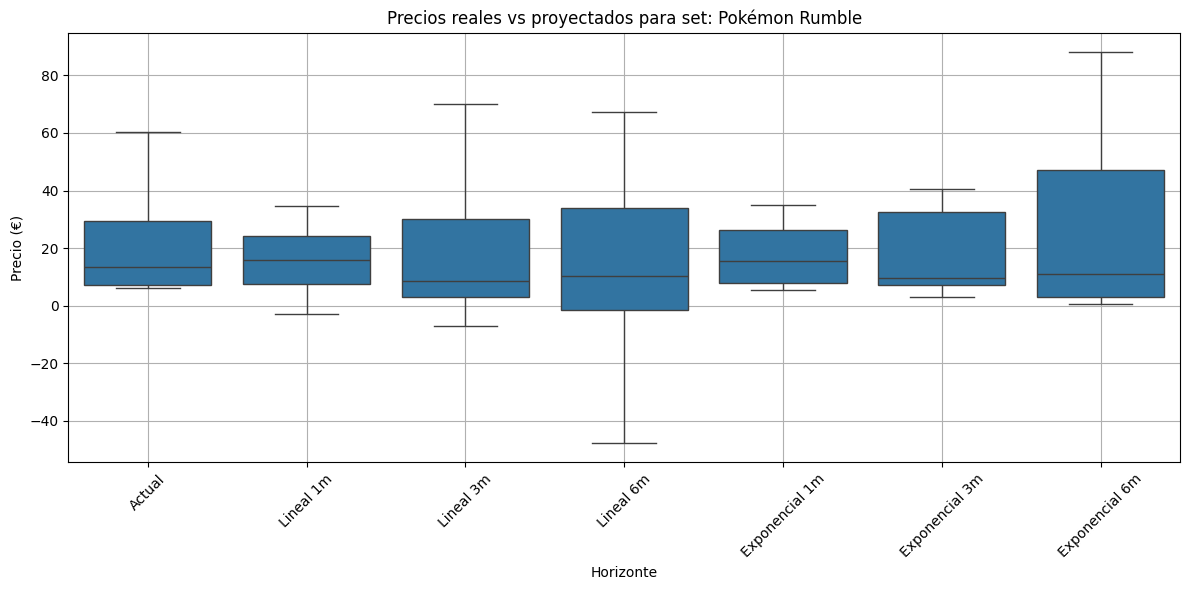

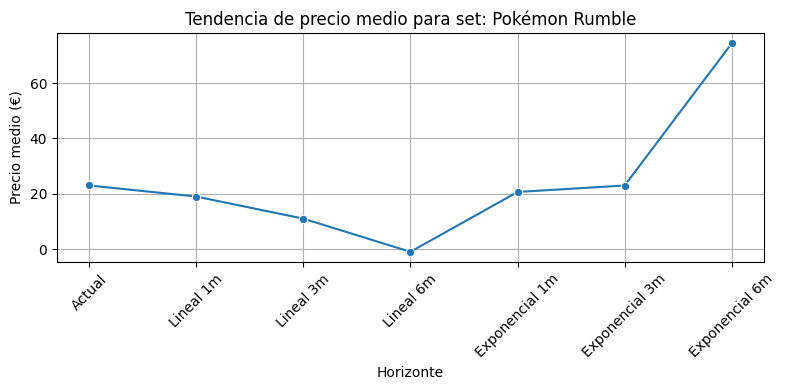

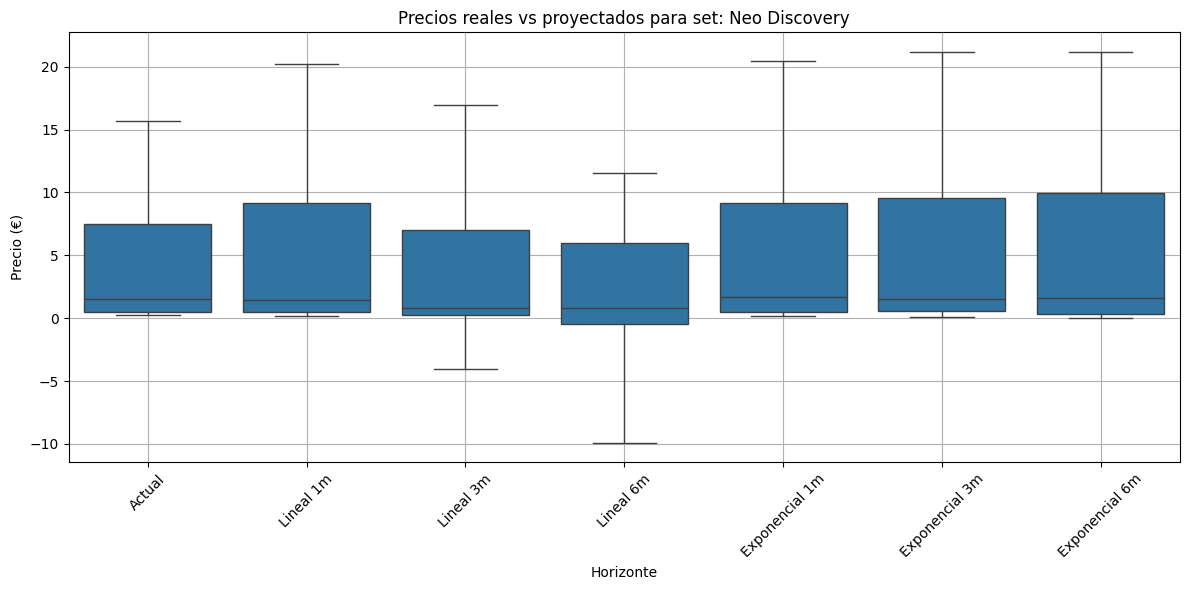

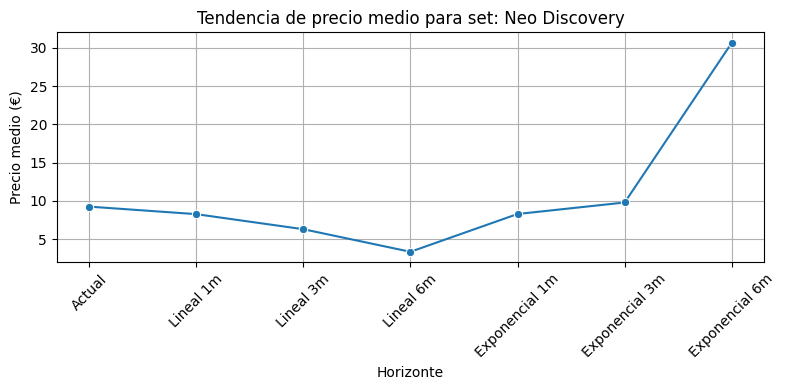

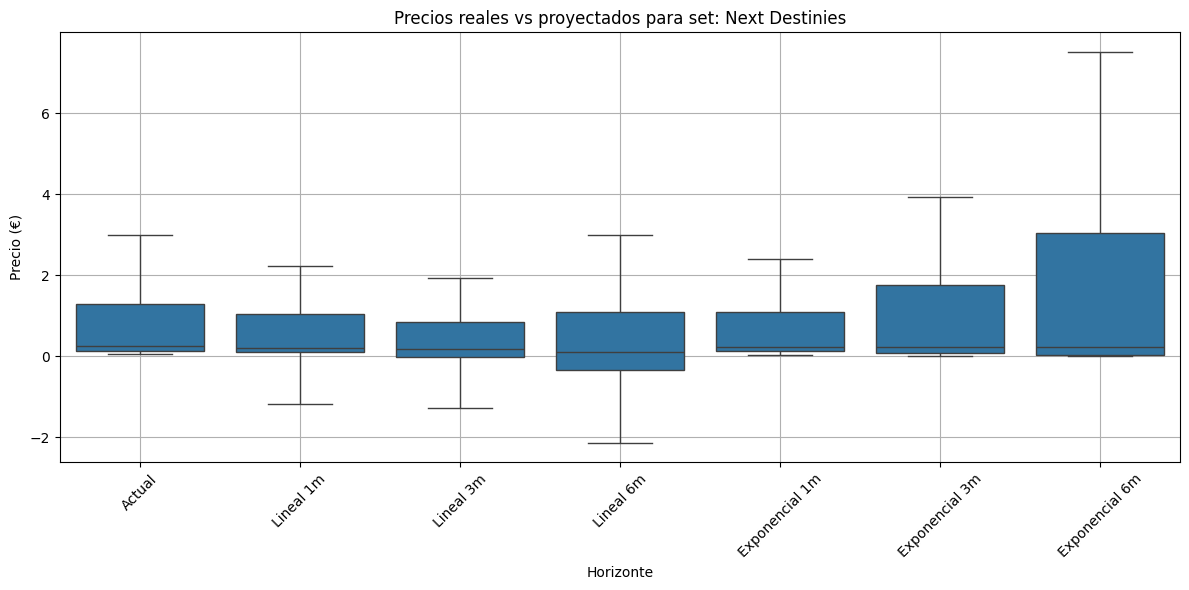

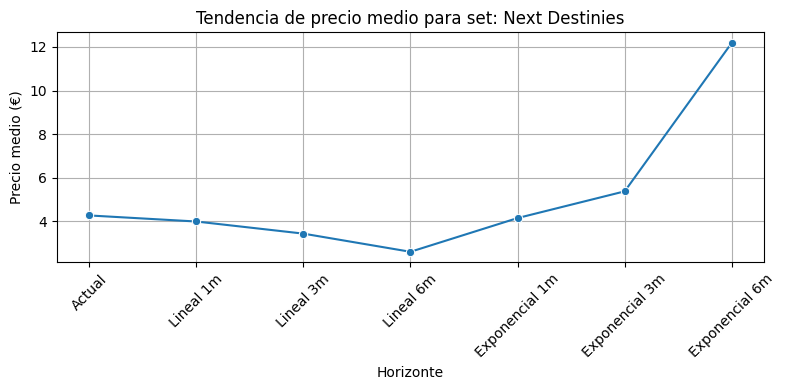

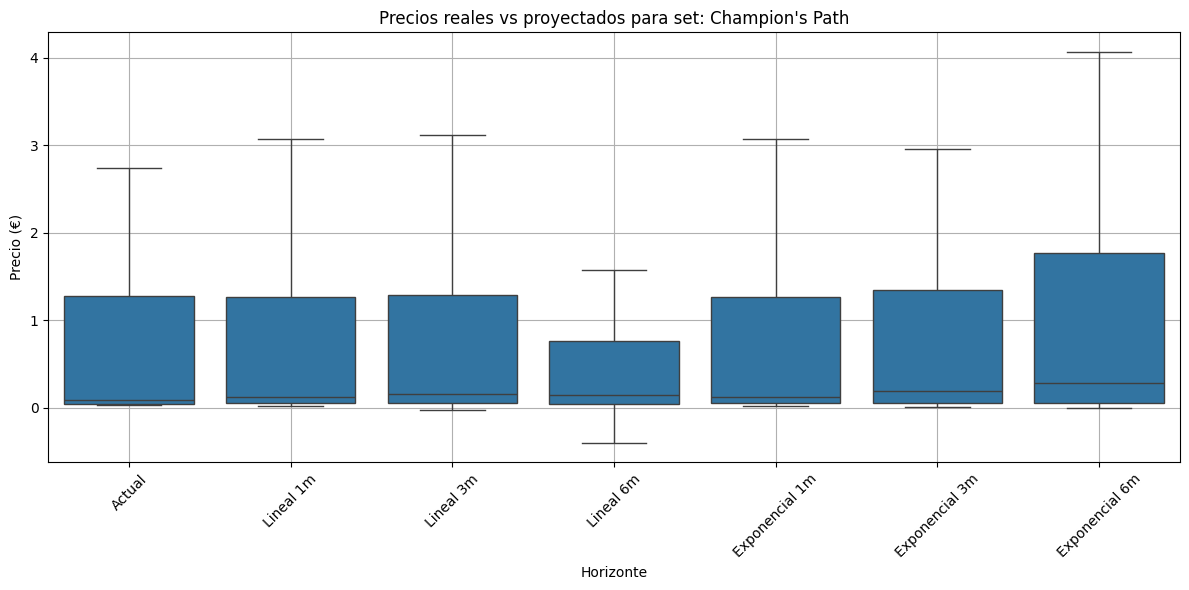

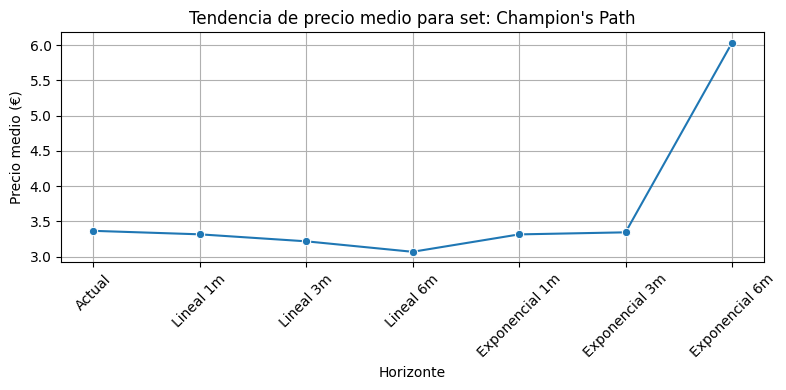

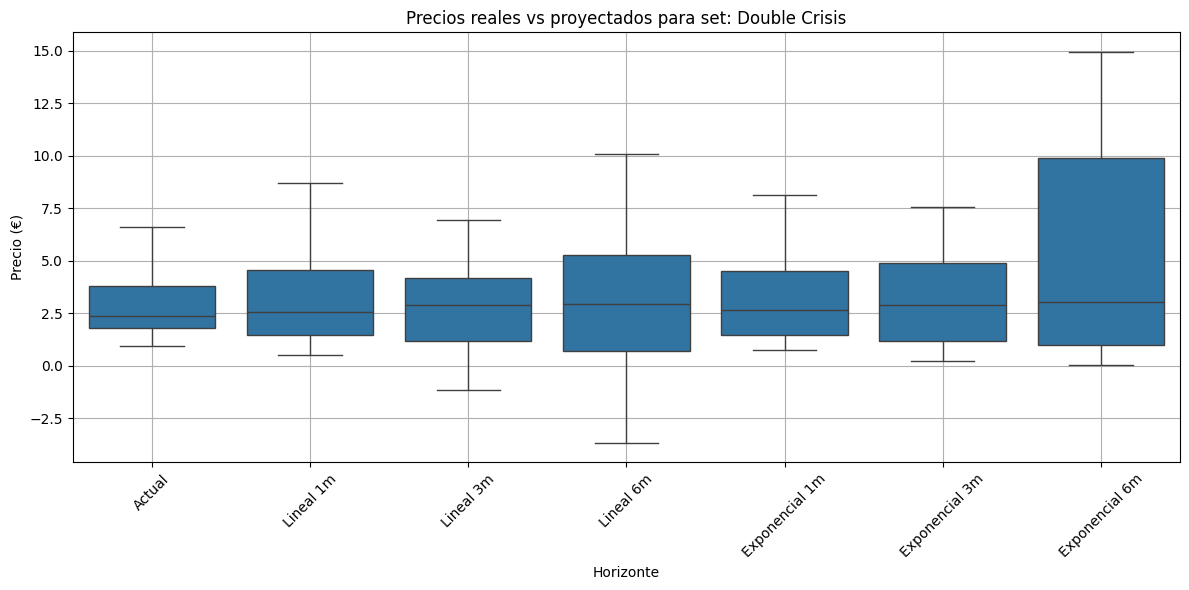

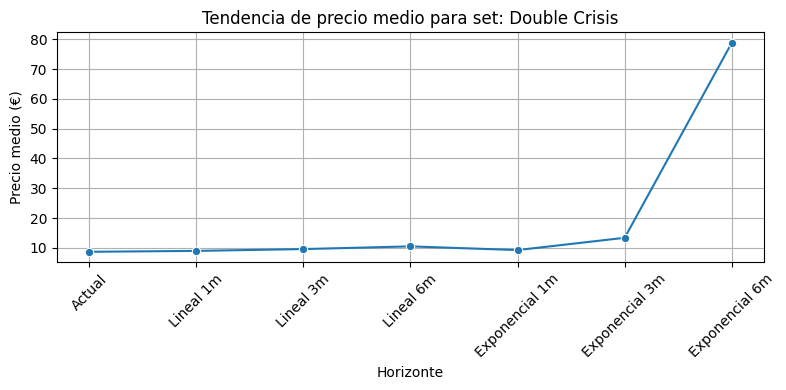

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1) Asegurarse de tener df_resultado con datos y predicciones actuales
columnas_seguras = list(set(
    numeric_features + categorical_features +
    ['name', 'rarity', 'set_name', 'cm_averageSellPrice', 'cm_avg7', 'cm_avg30']
))
df_resultado = df[columnas_seguras].dropna().copy()
df_resultado["Precio estimado"] = predict_mixed(df_resultado[numeric_features + categorical_features])

# 2) Calcular errores actuales
df_resultado["Diferencia (€)"]   = df_resultado["cm_averageSellPrice"] - df_resultado["Precio estimado"]
df_resultado["Error absoluto"]   = np.abs(df_resultado["Diferencia (€)"])

# 3) Tasa de cambio diaria lineal (entre avg7 y avg30)
df_resultado['daily_delta_lin'] = (df_resultado['cm_avg7'] - df_resultado['cm_avg30']) / (30 - 7)

# 4) Proyección lineal a 1m, 3m, 6m
for days, label in [(30, '1m'), (90, '3m'), (180, '6m')]:
    df_resultado[f'pred_lin_{label}'] = df_resultado['cm_averageSellPrice'] + df_resultado['daily_delta_lin'] * days

# 5) Factor de crecimiento diario exponencial
df_resultado['daily_factor_exp'] = (df_resultado['cm_avg7'] / df_resultado['cm_avg30']) ** (1/(30-7))

# 6) Proyección exponencial a 1m, 3m, 6m
for days, label in [(30, '1m'), (90, '3m'), (180, '6m')]:
    df_resultado[f'pred_exp_{label}'] = df_resultado['cm_averageSellPrice'] * (df_resultado['daily_factor_exp'] ** days)

# 7) Elegir 5 sets al azar
sets_aleatorios = np.random.choice(df_resultado['set_name'].unique(), size=5, replace=False)

# 8) Para cada set, graficar
for s in sets_aleatorios:
    df_set = df_resultado[df_resultado['set_name'] == s]
    if df_set.empty:
        continue

    # Preparar DataFrame largo
    df_plot = df_set[[
        'cm_averageSellPrice',
        'pred_lin_1m', 'pred_lin_3m', 'pred_lin_6m',
        'pred_exp_1m', 'pred_exp_3m', 'pred_exp_6m'
    ]].copy()
    df_long = df_plot.melt(
        var_name='Horizonte',
        value_name='Precio (€)',
        value_vars=df_plot.columns
    )
    df_long['Horizonte'] = df_long['Horizonte'].map({
        'cm_averageSellPrice': 'Actual',
        'pred_lin_1m': 'Lineal 1m',
        'pred_lin_3m': 'Lineal 3m',
        'pred_lin_6m': 'Lineal 6m',
        'pred_exp_1m': 'Exponencial 1m',
        'pred_exp_3m': 'Exponencial 3m',
        'pred_exp_6m': 'Exponencial 6m',
    })

    # Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_long, x='Horizonte', y='Precio (€)', showfliers=False)
    plt.title(f"Precios reales vs proyectados para set: {s}")
    plt.xlabel("Horizonte")
    plt.ylabel("Precio (€)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Tendencia de precio medio
    medias = df_long.groupby('Horizonte')['Precio (€)'].mean().reindex([
        'Actual', 'Lineal 1m', 'Lineal 3m', 'Lineal 6m',
        'Exponencial 1m', 'Exponencial 3m', 'Exponencial 6m'
    ])
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=medias.index, y=medias.values, marker='o')
    plt.title(f"Tendencia de precio medio para set: {s}")
    plt.xlabel("Horizonte")
    plt.ylabel("Precio medio (€)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [58]:
import joblib

# Ruta en tu Drive o en tu repo
joblib.dump(pipe_low, "/content/drive/MyDrive/Proyecto API/Modelos/Low/modelo_pipe_low.pkl")
joblib.dump(pipe_high, "/content/drive/MyDrive/Proyecto API/Modelos/High/modelo_pipe_high.pkl")

# Guarda también el umbral en un pequeño JSON o variable
import json
with open("/content/drive/MyDrive/Proyecto API/Modelos/threshold.json", "w") as f:
    json.dump({"threshold": threshold}, f)

print("✅ Modelos y umbral guardados.")


✅ Modelos y umbral guardados.
